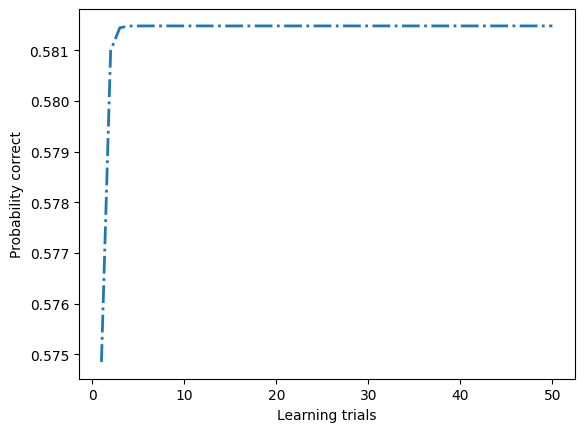

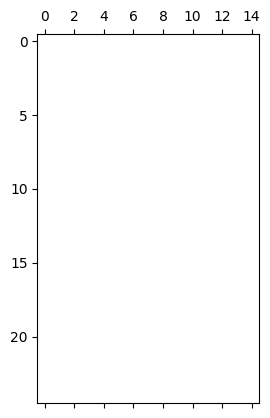

Proportion of correct patterns: 0.0


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset function
def load_data():
    file_path = "Gender & Pronouns survey (Responses) - Form Responses 1.csv"
    data = pd.read_csv(file_path)

    # Select relevant columns
    input_columns = [
        "Based on your Physical Appearance, select one that best identifies you",
        "What is your Dressing Style?",
        "How do you identify yourself (Self-Identification)?"
    ]
    target_columns = ["What is your Gender Category?", "What is your Pronoun(s)?"]

    # Drop rows with missing values in essential columns
    data_cleaned = data[input_columns + target_columns].dropna()

    # Encode categorical text data into numerical values
    label_encoders = {}
    for col in input_columns + target_columns:
        le = LabelEncoder()
        data_cleaned[col] = le.fit_transform(data_cleaned[col])
        label_encoders[col] = le  # Store encoders for future use

    # Normalize input data
    scaler = MinMaxScaler()
    X = scaler.fit_transform(data_cleaned[input_columns].values)  # Normalize to range [0, 1]
    Y = data_cleaned[target_columns].values  # Last 2 columns as output
    return X, Y

# Define the input-output function
def in_out(I1, I2, I3, X, W, sig, st):
    """Compute output given input features and weights."""
    in1 = np.exp(-((I1 - X[st, 0]) / sig) ** 2)
    in2 = np.exp(-((I2 - X[st, 1]) / sig) ** 2)
    in3 = np.exp(-((I3 - X[st, 2]) / sig) ** 2)
    In = np.array([in1, in2, in3])
    
    # Weighted sum
    Out = np.dot(W, In)
    return Out

# Exemplar function with smoother updates
def exemplar(alf, b, sig, X, Y, nr, cutoff, W=None):
    ns = X.shape[0]
    if W is None:
        W = np.zeros((Y.shape[1], X.shape[1]))
    T = np.zeros((nr, Y.shape[1]))
    mT = np.zeros(nr)
    
    smooth_factor = 0.1  # Smoothing factor to stabilize updates

    for rep in range(nr):
        for st in range(ns):
            Out = in_out(X[st, 0], X[st, 1], X[st, 2], X, W, sig, st)
            grad = (Y[st].reshape(-1, 1) - Out.reshape(-1, 1)) @ np.array([X[st]])
            grad = np.clip(grad, -0.1, 0.1)  # Restrict updates for stability
            W += alf * grad
            W = (1 - smooth_factor) * W + smooth_factor * grad  # Apply smoothing
        
        for st in range(Y.shape[1]):
            Out = in_out(X[st, 0], X[st, 1], X[st, 2], X, W, sig, st)
            Out = Out - np.max(Out)  # Prevent numerical instability
            pa = np.exp(b * Out) / np.sum(np.exp(b * Out))
            T[rep, st] = pa[0]

        mT[rep] = ((T[rep, 1] - T[rep, 0]) > cutoff).astype(float)

        # Debugging output
        #print(f"Iteration {rep+1}: Weight Mean {np.mean(W):.6f}, T {T[rep]}")

    return mT, T, W

# Main program
def main():
    X, Y = load_data()
    
    nr = 50
    alf = 0.05  # Reduced learning rate for smoother convergence
    b = 2.5
    sig = 5
    cutoff = 0.2

    mT, T, W = exemplar(alf, b, sig, X, Y, nr, cutoff)
    
    plt.figure()
    plt.plot(range(1, nr + 1), (T[:, 1] + T[:, 0]) / 2, '-.', linewidth=2)
    plt.xlabel('Learning trials')
    plt.ylabel('Probability correct')
    plt.show()

    # Compute and display proportion of correct patterns
    aa = 25
    bb = 15
    AV = np.linspace(0.01, 1.0, aa)
    BV = np.linspace(0.5, 3.0, bb)
    MT = np.zeros((aa, bb))

    for i in range(aa):
        for j in range(bb):
            alf_current = AV[i]
            b_current = BV[j]
            mT, _, _ = exemplar(alf_current, b_current, sig, X, Y, nr, cutoff, W)
            MT[i, j] = mT[-1]

    plt.figure()
    plt.spy(MT)
    plt.show()

    pcp = np.sum(MT == 1) / (MT.shape[0] * MT.shape[1])
    print('Proportion of correct patterns:', pcp)

if __name__ == "__main__":
    main()